<a href="https://colab.research.google.com/github/ruzan-ai/churn_project_end_to_end/blob/main/Exp2_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Telco Churn Prediction - Full Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 1. Load Data
file_path = "/content/drive/MyDrive/Data Set/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(file_path)

In [21]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Cluster,PCA1,PCA2
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,3,-0.427370,-3.153947
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,One year,No,Mailed check,56.95,1889.50,No,4,-0.200847,-0.796894
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,4,-0.157537,-2.092467
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3,-0.893278,-0.882617
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,4,-0.609394,-3.172786


In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop(columns=['customerID'], inplace=True)


In [22]:
# STEP 3: Encode 'Churn' as binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [6]:
# Encode categorical features
df_encoded = pd.get_dummies(df.drop(columns=['Churn']), drop_first=True)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

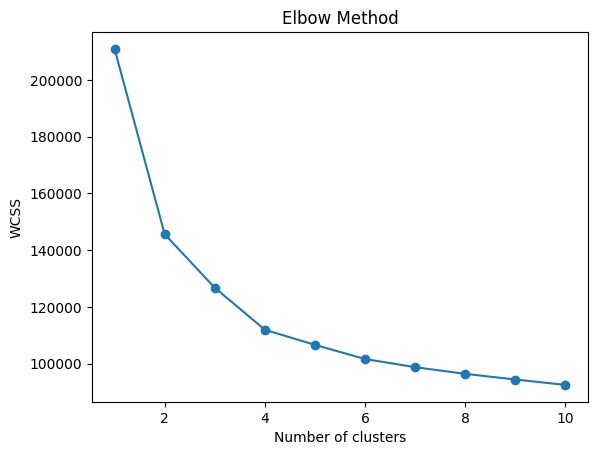

In [10]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [11]:
# when the curve starts to flatten and there is a elbow shape we make the curve flattening / we select the number of clusters in the data set.
#✅ What is WCSS?
#WCSS = Within-Cluster Sum of Squares

# It’s a metric used in K-Means clustering to measure how tightly grouped the data points in each cluster are.

In [15]:
k = 5  # change based on elbow result
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = clusters

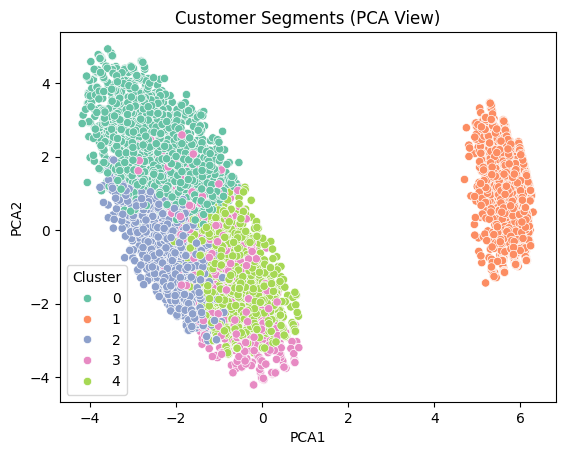

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Customer Segments (PCA View)")
plt.show()

In [18]:
# Filter numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns

# Group by cluster and take mean of numeric features only
cluster_summary = df.groupby('Cluster')[numeric_cols].mean().round(2)

# Show top behavioral features
display(cluster_summary[['tenure', 'MonthlyCharges', 'TotalCharges']])

,tenure,MonthlyCharges,TotalCharges
Cluster,,,
0,58.97,91.10,5416.80
1,30.67,21.08,665.22
2,27.57,91.72,2555.77
3,31.83,41.99,1500.43
4,14.12,65.12,913.01


In [26]:
cluster_summary.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Cluster,PCA1,PCA2
Cluster,,,,,,,
0,0.13,58.97,91.10,5416.80,0.0,-2.50,2.25
1,0.03,30.67,21.08,665.22,1.0,5.73,0.81
2,0.41,27.57,91.72,2555.77,2.0,-2.06,-0.72
3,0.15,31.83,41.99,1500.43,3.0,-0.91,-1.28
4,0.10,14.12,65.12,913.01,4.0,-0.61,-1.65


In [23]:
# STEP 5: Calculate churn rate per cluster
churn_summary = df.groupby('Cluster')['Churn'].mean().reset_index()
churn_summary['ChurnRate (%)'] = churn_summary['Churn'] * 100


In [25]:
churn_summary.head()

,Cluster,Churn,ChurnRate (%)
0,0,0.097318,9.731753
1,1,0.074342,7.434211
2,2,0.512697,51.269732
3,3,0.250000,25.000000
4,4,0.385440,38.544018


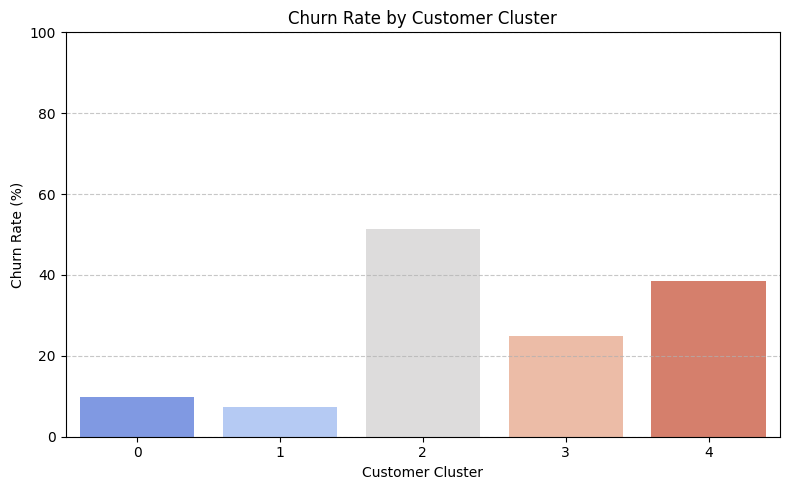

In [24]:
# STEP 6: Plot churn rate by cluster
plt.figure(figsize=(8, 5))
sns.barplot(data=churn_summary, x='Cluster', y='ChurnRate (%)', palette='coolwarm')
plt.title("Churn Rate by Customer Cluster")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Customer Cluster")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()